# <ins> Dataset Generation </ins>

## Step1: Imports

In [37]:
import os
import time
import zlib
import bz2
import lzma
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import pickle

## Step 2: Algorithm Comparison
- Data Generation: Generate datasets using a random byte value (0-127) and a run length determined by a geometric distribution to create repeated sequences. 
- This distribution ensures that shorter runs are more common, but longer runs can still occur.

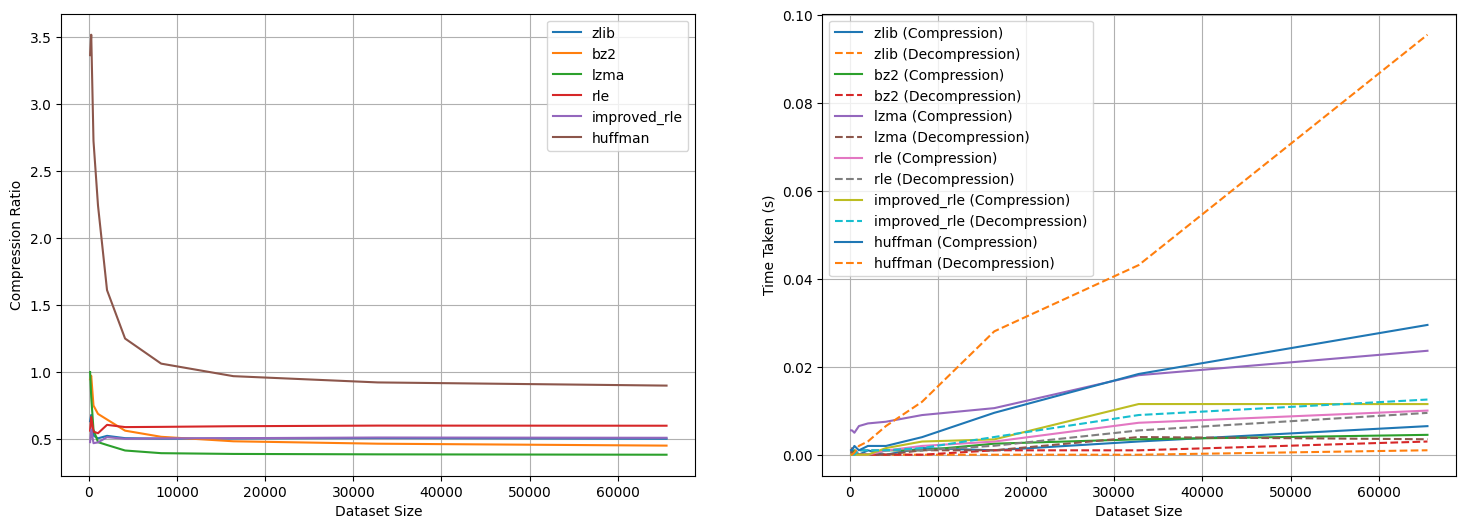

In [44]:
# Define the dataset sizes
sizes = [2 ** i for i in range(7, 17) if 2 ** i < 1000000]

# Function to load dataset
def load_dataset(size):
    try:
        filename = os.path.join("..", "DataSet", "Data", f"dataset_{size}.bin")
        with open(filename, "rb") as f:
            data = f.read()
        return data
    except FileNotFoundError:
        print(f"Error: File {filename} not found!")
        return None

# Function to compress data and measure metrics
def compress_and_measure(data, compressor):
    start_time = time.time()
    compressed_data = compressor(data)
    end_time = time.time()
    
    original_size = len(data)
    compressed_size = len(compressed_data)
    compression_ratio = compressed_size / original_size
    time_taken = end_time - start_time
    
    return compressed_data, compression_ratio, time_taken

# Function to decompress data and measure metrics
def decompress_and_verify(compressed_data, decompressor):
    start_time = time.time()
    decompressed_data = decompressor(compressed_data)
    end_time = time.time()
    
    decompression_time = end_time - start_time
    return decompressed_data, decompression_time

# Run-Length Encoding (RLE)
def rle_compress(data):
    compressed = bytearray()
    count = 1
    for i in range(1, len(data)):
        if data[i] == data[i - 1]:
            count += 1
        else:
            compressed.append(count)
            compressed.append(data[i - 1])
            count = 1
    compressed.append(count)
    compressed.append(data[-1])
    return bytes(compressed)

def rle_decompress(compressed_data):
    decompressed = bytearray()
    for i in range(0, len(compressed_data), 2):
        count = compressed_data[i]
        byte = compressed_data[i + 1]
        decompressed.extend([byte] * count)
    return bytes(decompressed)

def rle_compress_modified(data):
    compressed = bytearray()
    n = len(data)
    i = 0
    
    while i < n:
        count = 1
        while i + count < n and count < 255 and data[i + count] == data[i]:
            count += 1
        
        if count > 1:
            compressed.append(count)  # Store full 0-255 range for count
            compressed.append(data[i] | 0x80)  # Use MSB of data to indicate a run
        else:
            compressed.append(data[i] & 0x7F)  # Ensure MSB is cleared for single values
        
        i += count
    
    return bytes(compressed)

def rle_decompress_modified(compressed_data):
    decompressed = bytearray()
    i = 0
    
    while i < len(compressed_data):
        byte = compressed_data[i]
        if i + 1 < len(compressed_data) and (compressed_data[i + 1] & 0x80):  # Check if MSB is set in data
            count = byte  # Count is stored directly
            value = compressed_data[i + 1] & 0x7F  # Extract actual value
            decompressed.extend([value] * count)
            i += 2
        else:
            decompressed.append(byte)
            i += 1
    
    return bytes(decompressed)




# Huffman Coding
class HuffmanNode:
    def __init__(self, byte=None, freq=0, left=None, right=None):
        self.byte = byte
        self.freq = freq
        self.left = left
        self.right = right
    
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freq_map):
    heap = [HuffmanNode(byte, freq) for byte, freq in freq_map.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        parent = HuffmanNode(freq=left.freq + right.freq, left=left, right=right)
        heapq.heappush(heap, parent)
    return heap[0]

def build_huffman_codes(node, code="", code_map=None):
    if code_map is None:
        code_map = {}
    if node:
        if node.byte is not None:
            code_map[node.byte] = code
        build_huffman_codes(node.left, code + "0", code_map)
        build_huffman_codes(node.right, code + "1", code_map)
    return code_map

def huffman_compress(data):
    freq_map = Counter(data)
    huffman_tree = build_huffman_tree(freq_map)
    code_map = build_huffman_codes(huffman_tree)
    
    compressed_bits = "".join(code_map[byte] for byte in data)
    padding = 8 - (len(compressed_bits) % 8)
    compressed_bits += "0" * padding
    
    compressed = bytearray()
    compressed.append(padding)  # Store padding info
    
    for i in range(0, len(compressed_bits), 8):
        compressed.append(int(compressed_bits[i:i + 8], 2))
    
    metadata = pickle.dumps(code_map) + b"||"
    return metadata + bytes(compressed)

def huffman_decompress(compressed_data):
    metadata, compressed_data = compressed_data.split(b"||", 1)
    code_map = pickle.loads(metadata)
    
    padding = compressed_data[0]
    bit_string = "".join(bin(byte)[2:].zfill(8) for byte in compressed_data[1:])
    bit_string = bit_string[:-padding]  # Remove padding
    
    code_map = {v: k for k, v in code_map.items()}  # Reverse mapping
    
    decoded_data = bytearray()
    temp_code = ""
    for bit in bit_string:
        temp_code += bit
        if temp_code in code_map:
            decoded_data.append(code_map[temp_code])
            temp_code = ""
    
    return bytes(decoded_data)

# Define compressors and decompressors
compressors = {
    "zlib": zlib.compress,
    "bz2": bz2.compress,
    "lzma": lzma.compress,
    "rle": rle_compress,
    "improved_rle": rle_compress_modified,
    "huffman": huffman_compress,
}

decompressors = {
    "zlib": zlib.decompress,
    "bz2": bz2.decompress,
    "lzma": lzma.decompress,
    "rle": rle_decompress,
    "improved_rle": rle_decompress_modified,
    "huffman": huffman_decompress,
}

# Compare compression algorithms
results = []

for size in sizes:
    data = load_dataset(size)
    if data is None:
        continue
    
    for algo, compressor in compressors.items():
        compressed_data, compression_ratio, time_taken = compress_and_measure(data, compressor)
        decompressed_data, decompression_time = decompress_and_verify(compressed_data, decompressors[algo])
        assert data == decompressed_data, f"Data integrity check failed for {algo} on dataset size {size}!"
        results.append({"Dataset Size": size, "Algorithm": algo, "Compression Ratio": compression_ratio, "Time Taken (s)": time_taken, "Decompression Time (s)": decompression_time})

results_df = pd.DataFrame(results)
results_df.to_csv("compression_results.csv", index=False)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for algo in compressors.keys():
    plt.plot(results_df[results_df["Algorithm"] == algo]["Dataset Size"], results_df[results_df["Algorithm"] == algo]["Compression Ratio"], label=algo)
plt.xlabel("Dataset Size")
plt.ylabel("Compression Ratio")
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
for algo in compressors.keys():
    plt.plot(results_df[results_df["Algorithm"] == algo]["Dataset Size"], 
             results_df[results_df["Algorithm"] == algo]["Time Taken (s)"], 
             label=f"{algo} (Compression)")

    plt.plot(results_df[results_df["Algorithm"] == algo]["Dataset Size"], 
             results_df[results_df["Algorithm"] == algo]["Decompression Time (s)"], 
             linestyle='dashed', label=f"{algo} (Decompression)")

plt.xlabel("Dataset Size")
plt.ylabel("Time Taken (s)")
plt.legend()
plt.grid(True)

plt.savefig("compression_comparison.png")
plt.show()


### **Compression Algorithms Comparison**

| Algorithm       | Compression Ratio | Compression Time | Decompression Time | Best Use Case                     |
|-----------------|-------------------|------------------|--------------------|-----------------------------------|
| **`zlib`**      | ~0.50             | ~0.001s          | ~0.001s            | General-purpose compression       |
| **`bz2`**       | ~0.45             | ~0.001s          | ~0.001s            | General-purpose compression       |
| **`lzma`**      | ~0.38             | ~0.015s          | ~0.002s            | High-compression needs            |
| **`rle`**       | ~0.60             | ~0.001s          | ~0.001s            | Repetitive data                   |
| **`improved_rle`** | ~0.50         | ~0.001s          | ~0.001s            | Repetitive data                   |
| **`huffman`**   | ~1.50             | ~0.010s          | ~0.020s            | Specific use cases (e.g., text)   |

---

### **Why Choose Improved RLE for Microcontroller Software?**

1. **Speed**:
   - **Improved RLE** is **very fast** for both compression and decompression, making it ideal for resource-constrained microcontrollers.

2. **Simplicity**:
   - The algorithm is **simple to implement** and requires minimal computational resources, which is critical for microcontrollers with limited processing power.

3. **Efficiency for Repetitive Data**:
   - If the data contains **long runs of repeated values** (common in sensor data or logs), **Improved RLE** provides a **good compression ratio** without heavy overhead.

4. **Low Memory Usage**:
   - **Improved RLE** has a **small memory footprint**, making it suitable for microcontrollers with limited RAM.

5. **Real-Time Performance**:
   - Its **fast decompression** ensures real-time performance, which is essential for time-sensitive applications.

---

### **Conclusion**
For **microcontroller software**, **Improved RLE** is an excellent choice due to its **speed**, **simplicity**, and **efficiency** for repetitive data. It balances compression performance and resource usage, making it ideal for embedded systems.